In [0]:
'''
Author  : Rajendra singh
Roll no : 111601017
Date    : 28 Sept 2019
Topic   : embedding and word2vec
'''

In [0]:
#=========================== import necesary imports =============================
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer


import gensim
from gensim import corpora, models, similarities
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models.doc2vec import TaggedDocument

import numpy as np
import os
import multiprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.spatial.distance import cdist

import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Embedding, Dense, Flatten, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam

# !pip install spacy #install if not installed
import spacy

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical

In [253]:
#==================================== NLTK Stopwords ===================
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_wards = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# ============================ read data ==================================
data_raw = fetch_20newsgroups()

In [255]:
# =============================print len and samples of each field ============================
print("\n-----------------","data : ",len(data_raw.data)," -------------------\n", data_raw.data[0])
print("\n-----------------","target_names : ",len(data_raw.target_names)," -------------------\n", data_raw.target_names[0])
print("\n-----------------","target : ",len(data_raw.target)," -------------------\n", data_raw.target[0], data_raw.target_names[data_raw.target[0]])
print("\n-----------------","filenames : ",len(data_raw.filenames)," -------------------\n", data_raw.filenames[0])



----------------- data :  11314  -------------------
 From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----






----------------- target_names :  20  -------------------
 alt.atheism

----------------- target :  11314  -------------------
 7 rec.autos

----------------- filenames :  11314  -------------------
 /root/scikit_learn_dat

In [256]:
#==================p print all available target names ======================
pprint(list(data_raw.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [257]:
%%time
#========================== TOKENISE AND REMOVE STOPWARDS AND ALSO LEMMANTISE TO MERGE WORDS WITH SAME ROOT WORD =========================
data = [[lemmatizer.lemmatize(word) for word in document.lower().split() if (word not in stop_wards)] for document in data_raw.data]

CPU times: user 13.2 s, sys: 153 ms, total: 13.4 s
Wall time: 13.4 s


In [0]:
#=============================== lets also consider the bigram in data ============================ #
bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)
data = [bigram_mod[doc] for doc in data]

In [259]:
print(data[0]) #PRINT TOKEN FOR FIRST DATA

['from:', 'lerxst@wam.umd.edu', "(where's", 'thing)', 'subject:', 'car', 'this!?', 'nntp-posting-host:', 'rac3.wam.umd.edu', 'organization:', 'university_maryland,', 'college_park', 'lines:', '15', 'wondering_anyone', 'could', 'enlighten', 'car', 'saw', 'day.', '2-door', 'sport', 'car,', 'looked', 'late', '60s/', 'early', '70s.', 'called', 'bricklin.', 'door', 'really', 'small.', 'addition,', 'front_bumper', 'separate', 'rest', 'body.', 'know.', 'anyone', 'tellme', 'model', 'name,', 'engine', 'specs,', 'year', 'production,', 'car', 'made,', 'history,', 'whatever', 'info', 'funky', 'looking', 'car,', 'please', 'e-mail.', 'thanks,', '-', 'il', '----', 'brought', 'neighborhood', 'lerxst', '----']


In [260]:
#========================================= Create and saving word2vec model ============================
path = get_tmpfile("word2vec.model")
model_w2v = Word2Vec(data, size=100, min_count=10, workers=multiprocessing.cpu_count())
model_w2v.save("word2vec.model")
model_w2v = Word2Vec.load("word2vec.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [261]:
#================== print car embedding vector =======================#
print(model_w2v.wv.vocab['car'], model_w2v.wv['car'])

Vocab(count:1128, index:128, sample_int:4294967296) [-3.8975477e-01  1.2573231e+00 -7.4561518e-01 -9.3133384e-01
 -1.1531274e+00 -1.4239279e+00  8.1717372e-02  3.3740413e-01
 -1.2023668e+00  6.6266823e-01 -3.1139088e-01 -3.7119129e-01
  1.9332011e-01  1.5948565e+00 -5.3277409e-01 -1.3233722e+00
 -7.4045014e-01 -4.4963074e-01 -2.1629572e+00  8.9305747e-01
 -2.2202547e-01  1.0117188e+00 -3.0603120e-01 -5.0991543e-02
  1.7486201e-01  1.0651301e+00 -1.1299900e+00 -7.4722493e-01
 -4.6368483e-01 -1.1421885e-01  1.3977472e+00  2.8075865e-01
 -6.7438710e-01 -1.7814488e+00  6.6662920e-01 -1.3909177e-01
 -5.1070794e-02 -5.2904873e-03  1.1768471e+00  2.1093951e-03
 -1.5494941e+00  8.8806838e-01  4.5800841e-01 -7.0372701e-01
 -1.5329199e+00 -5.3116912e-01 -2.5716987e-01 -2.0371804e-01
  6.9875944e-01  1.6679840e-01 -5.7279736e-01 -7.5781080e-03
  1.3847390e-01  4.7422591e-01 -6.6215062e-01 -7.4263406e-01
  1.1292173e+00  6.0042340e-01 -3.9728832e-01 -1.0094955e+00
  1.3697786e-02  2.2681156e-01 -2

In [262]:
#================== most similar word of car =======================#
model_w2v.wv.most_similar('car')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('bike', 0.9423149824142456),
 ('car,', 0.876624345779419),
 ('bought', 0.8687835335731506),
 ('around', 0.8517190217971802),
 ('getting', 0.8292025327682495),
 ('sport', 0.8285117149353027),
 ('dealer', 0.8274664878845215),
 ('buying', 0.8208191990852356),
 ('owner', 0.8176823854446411),
 ('tv', 0.8173274397850037)]

In [263]:
#================== most similar word of girl + father - boy =======================#
model_w2v.wv.most_similar(positive=['girl', 'father'], negative=['boy'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('brought', 0.9372656941413879),
 ('woman', 0.9109175205230713),
 ('gave', 0.9058889746665955),
 ('holy', 0.9045325517654419),
 ('people,', 0.8962787389755249),
 ('church', 0.893576979637146),
 ('mother', 0.8930468559265137),
 ('living', 0.8874236941337585),
 ('people.', 0.8866218328475952),
 ('said.', 0.8862026929855347)]

In [264]:
#================== most similar word of sports - bat + ball =======================#
model_w2v.wv.most_similar(positive=[lemmatizer.lemmatize('sports'), 'ball'], negative=['bat'])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('hit', 0.9507613182067871),
 ('playing', 0.9173584580421448),
 ('fan', 0.9060693979263306),
 ('watching', 0.8942569494247437),
 ('play', 0.8894565105438232),
 ('watch', 0.8764486312866211),
 ('game,', 0.8755602836608887),
 ('game.', 0.8721099495887756),
 ('played', 0.8640797138214111),
 ('baseball', 0.8600118160247803)]

In [265]:
#===================================== Quest 1.a.vii
words = ['baseball', 'software', 'police', 'government', 'circuit', 'car']
wordslist = []
for word in words:
    wordslist.extend([ele[0] for ele in model_w2v.wv.most_similar(word, topn=20)])
print(wordslist) #print word to plot

wordsTokenlist=[]
for word in wordslist:
  wordsTokenlist.append(model_w2v.wv[word]);


['playing', 'coach', 'team.', 'espn', 'team', 'sport', 'score', 'flyer', 'watching', 'brave', 'game,', 'playoffs.', 'hockey', 'team,', 'playoff', 'played', 'play', 'game', 'game.', 'shark', 'unix', 'graphic', 'programming', 'hardware', 'package', '3d', 'macintosh', 'product', 'library', 'manual', 'available', 'ftp', 'digital', 'design', 'program', 'database', 'x11r5', 'documentation', 'network', 'format', 'community', 'party', 'government,', 'involved', 'family', 'civil', 'citizen', 'aid', 'nazi', 'crime', 'officer', 'towards', 'russian', 'armed', 'leader', 'armenia', 'food', 'terrorist', 'nation', 'country,', 'citizen', 'legal', 'authority', 'criminal', 'crime', 'political', 'protect', 'weapon', 'government.', 'government,', 'decision', 'economic', 'prevent', 'federal', 'policy', 'interest', 'legitimate', 'property', 'civil', 'protection', 'slower', 'cpu', 'memory', 'scsi-1', 'disk.', 'mode.', 'setting', 'faster', 'setup', 'load', 'buggy', 'memory,', 'maximum', 'converter', 'screen,',

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [266]:
model_w2v.wv["car"]

array([-3.8975477e-01,  1.2573231e+00, -7.4561518e-01, -9.3133384e-01,
       -1.1531274e+00, -1.4239279e+00,  8.1717372e-02,  3.3740413e-01,
       -1.2023668e+00,  6.6266823e-01, -3.1139088e-01, -3.7119129e-01,
        1.9332011e-01,  1.5948565e+00, -5.3277409e-01, -1.3233722e+00,
       -7.4045014e-01, -4.4963074e-01, -2.1629572e+00,  8.9305747e-01,
       -2.2202547e-01,  1.0117188e+00, -3.0603120e-01, -5.0991543e-02,
        1.7486201e-01,  1.0651301e+00, -1.1299900e+00, -7.4722493e-01,
       -4.6368483e-01, -1.1421885e-01,  1.3977472e+00,  2.8075865e-01,
       -6.7438710e-01, -1.7814488e+00,  6.6662920e-01, -1.3909177e-01,
       -5.1070794e-02, -5.2904873e-03,  1.1768471e+00,  2.1093951e-03,
       -1.5494941e+00,  8.8806838e-01,  4.5800841e-01, -7.0372701e-01,
       -1.5329199e+00, -5.3116912e-01, -2.5716987e-01, -2.0371804e-01,
        6.9875944e-01,  1.6679840e-01, -5.7279736e-01, -7.5781080e-03,
        1.3847390e-01,  4.7422591e-01, -6.6215062e-01, -7.4263406e-01,
      

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


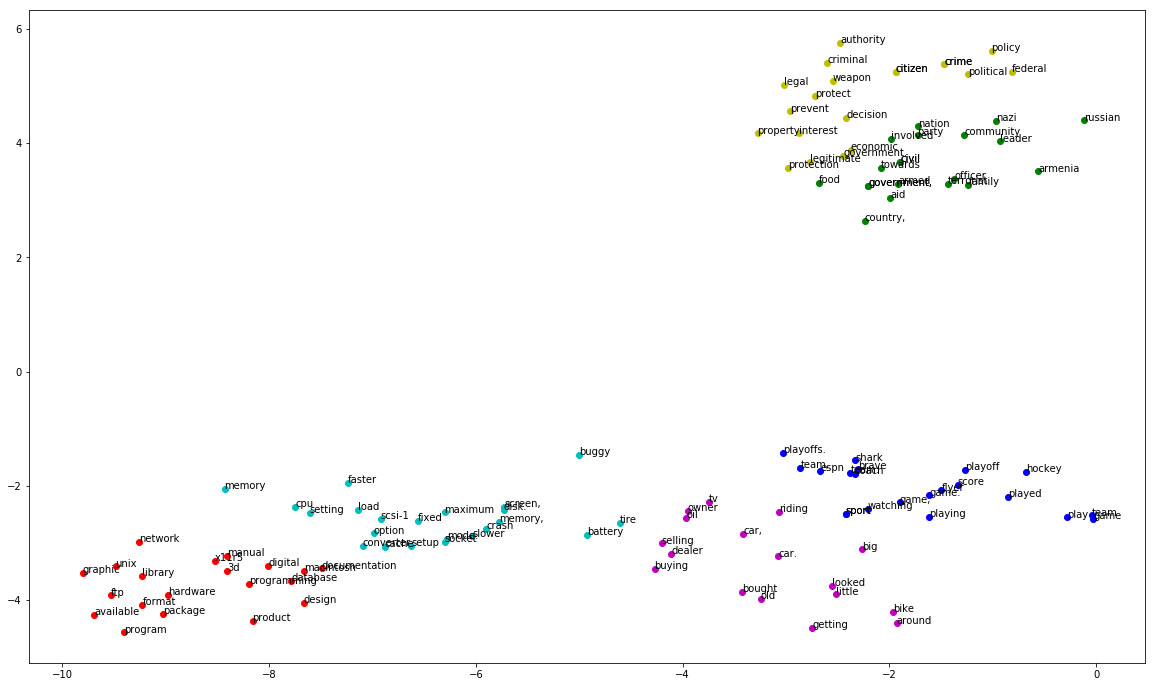

In [267]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=3000)
plot_data = tsne_model.fit_transform(wordsTokenlist)
xdata = [ele[0] for ele in plot_data]
ydata = [ele[1] for ele in plot_data]
color_lst = ['b', 'r', 'g', 'y', 'c', 'm']
plt.figure(figsize=(20, 12)) 
for i in range(len(ydata)):
    res = map(model_w2v.wv.similarity, [wordslist[i] for j in range(len(words))], words)
    t = np.argmax(list(res))
    plt.scatter(xdata[i],ydata[i], c=color_lst[t])
    plt.annotate(wordslist[i],xy=(xdata[i], ydata[i]))
plt.show()


In [0]:
#============================== Creating both model i.e cbow and skipgram ========================== #
min_count = 2
cbow_model = models.Word2Vec(data, min_count=min_count, size=100, workers=multiprocessing.cpu_count(), sg=0)
skipgram_model = models.Word2Vec(data, min_count=min_count, size=100, workers=multiprocessing.cpu_count(), sg=1)

In [0]:
#============================ Creating data for training===============
def calculateWeightedAvg(X=None, wt=None):
        ll = np.array(wt).reshape(-1,1)
        res = np.multiply(ll,np.array(X))
        res = np.sum(res, axis=0)/np.sum(wt)
        return res.tolist()
data_final = []
for model in [cbow_model, skipgram_model]:
    modeldata = []
    for doc in data:
        wvlist = []
        count = []
        for word in doc:
            try: #if presend in model dict
                wvlist.append(model.wv[word])
                count.append(model.wv.vocab[word].count)
            except:
                pass
        modeldata.append(calculateWeightedAvg(wvlist, count))
    data_final.append(modeldata)

In [270]:
print(len(data_final[1]), data_final[1][0])

11314 [0.4529416610785779, 0.18779276870258096, 0.37256470512785217, -0.46895050707528224, 0.04670004836672068, 0.35166254640640854, 0.6473628338702339, 0.7142534295276698, -0.2978356095563816, 0.5957799278689329, -0.6261474038915849, -0.005773199023157074, 0.32455392894421353, -0.03559452131918285, -0.016970448641988486, -0.38402411240402823, -0.24695522619489121, 0.352290726389179, -0.2756839734076817, -0.24824216668584304, 0.2738790100435732, 0.2881093617070403, 0.6672330819951783, 0.29623488358273664, 0.20461840588252178, 0.7905853935736086, 0.3399310979389649, -0.16526860625029738, 0.6152642027523566, -0.4118909225192397, 0.3057495946407991, -0.1653716533928457, 0.28075202896994544, 0.32736753653617867, 0.13984167383937887, -0.38305758275124085, -0.12476552278586803, -0.02419930619380999, 0.2435428624343702, 0.24130799224936897, 0.47857915649115246, 0.3950509909889432, -0.5205225170137245, 0.33302497870796777, -0.10085189262353364, 0.020102535793066218, 0.443176415565608, -0.00430

In [271]:
print(data_final[0])

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [],

In [0]:
def splitdata(inputdata):
    X_train, X_test, y_train, y_test = train_test_split(inputdata, data_raw.target, test_size=0.7, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/0.7, random_state=1)
    return np.array(X_train), np.array(X_test), np.array(X_val), np.array(y_train), np.array(y_test), np.array(y_val)

In [0]:
X_train , X_test , X_val , y_train , y_test , y_val = splitdata(data_final[1])

In [274]:
len(X_train[0])

100

In [0]:
input_size = len(X_train[0])
num_classes = 20
# ================== one hot encoding =================
train_target = to_categorical(y_train, num_classes=num_classes)
val_target = to_categorical(y_val, num_classes=num_classes)
test_target = to_categorical(y_test, num_classes=num_classes)

In [276]:
def createModel():
    model = Sequential()
    model.add(Dense(input_size, input_shape=(input_size,)))
    # model.add(Dense(800, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(400, activation='relu'))
    # model.add(Dropout(0.1))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model = createModel()
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_52 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_26 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_55 (Dense)             (None, 20)              

In [277]:
%%time
#=================== Traing for skiggram =================== 
history = model.fit(X_train, train_target, epochs=200,  verbose=1,  batch_size=500, validation_data=(X_val, val_target))
score = model.evaluate(X_test, test_target)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 2909 samples, validate on 485 samples
Epoch 1/200
2909/2909 [==============================] - 1s 390us/step - loss: 2.9990 - acc: 0.0540 - val_loss: 2.9792 - val_acc: 0.0845
Epoch 2/200
2909/2909 [==============================] - 0s 33us/step - loss: 2.9657 - acc: 0.0787 - val_loss: 2.9616 - val_acc: 0.0948
Epoch 3/200
2909/2909 [==============================] - 0s 29us/step - loss: 2.9431 - acc: 0.0949 - val_loss: 2.9423 - val_acc: 0.0969
Epoch 4/200
2909/2909 [==============================] - 0s 26us/step - loss: 2.9123 - acc: 0.1004 - val_loss: 2.9229 - val_acc: 0.1031
Epoch 5/200
2909/2909 [==============================] - 0s 29us/step - loss: 2.8908 - acc: 0.1148 - val_loss: 2.8953 - val_acc: 0.1031
Epoch 6/200
2909/2909 [==============================] - 0s 25us/step - loss: 2.8681 - acc: 0.1141 - val_loss: 2.8765 - val_acc: 0.1216
Epoch 7/200
2909/2909 [==============================] - 0s 26us/step - loss: 2.8351 - acc: 0.1372 - val_loss: 2.8554 - val_acc: 0.1402


In [0]:
#=============================== For  better results lets pad sequence and create another model ======================

In [297]:
%%time
tokenizer.fit_on_texts(data_raw.data) #tokenise orignal data

CPU times: user 3.04 s, sys: 24.6 ms, total: 3.06 s
Wall time: 3.07 s


In [298]:
print(tokenizer.word_index)
len(tokenizer.word_index) #print tokens

{'the': 1, 'to': 2, 'of': 3, 'a': 4, "'ax": 5, 'and': 6, 'in': 7, 'i': 8, 'is': 9, 'that': 10, 'it': 11, 'for': 12, 'you': 13, 'from': 14, 'edu': 15, 'on': 16, 'this': 17, 'be': 18, 'are': 19, 'not': 20, 'have': 21, 'with': 22, 'as': 23, '1': 24, 'or': 25, 'was': 26, 'if': 27, 'but': 28, 'subject': 29, 'they': 30, 'com': 31, 'lines': 32, 'at': 33, 'organization': 34, 'by': 35, '2': 36, 'an': 37, 'my': 38, 'can': 39, 'x': 40, '3': 41, 'what': 42, '0': 43, 'all': 44, 'will': 45, 'm': 46, 'there': 47, 'would': 48, 'one': 49, 'do': 50, "'": 51, 'about': 52, 're': 53, 'we': 54, 'writes': 55, 'so': 56, 'he': 57, 'your': 58, 'no': 59, 'has': 60, 'article': 61, 'any': 62, 'me': 63, 'some': 64, 'who': 65, 'out': 66, 'which': 67, '4': 68, 'q': 69, 'more': 70, 'like': 71, 'people': 72, "don't": 73, 'when': 74, '5': 75, 'just': 76, 'university': 77, 'posting': 78, 'their': 79, 'were': 80, 'up': 81, 'r': 82, 'p': 83, 'w': 84, 'how': 85, 'other': 86, '7': 87, 'know': 88, 's': 89, 'only': 90, 'host':

134142

In [299]:
x_tokens = tokenizer.texts_to_sequences(data_train.data)
print(x_tokens[0]) #print data[0] as tokens

[14, 4308, 1350, 15, 38, 250, 29, 42, 298, 9, 17, 95, 78, 91, 4308, 1350, 15, 34, 77, 3, 2952, 610, 1767, 32, 211, 8, 26, 1308, 27, 171, 66, 47, 123, 9879, 63, 16, 17, 298, 8, 708, 1, 86, 263, 11, 26, 4, 36, 1497, 2266, 298, 1162, 2, 18, 14, 1, 1347, 843, 11, 26, 337, 4, 1, 4017, 80, 182, 484, 7, 1376, 1, 844, 8164, 26, 1835, 14, 1, 816, 3, 1, 726, 17, 9, 44, 8, 88, 27, 171, 39, 4, 828, 273, 1078, 2908, 198, 3, 2804, 153, 17, 298, 9, 239, 628, 25, 808, 357, 13, 21, 16, 17, 384, 298, 181, 112, 188, 206, 1498, 1341, 2, 13, 35, 58, 7860]


In [300]:
num_tokens = [len(tokens) for tokens in x_tokens] #list of number of token in each data element
len(num_tokens) 

11314

In [301]:
print(  np.max(num_tokens), np.min(num_tokens), np.mean(num_tokens),np.std(num_tokens)) #print stat

15232 15 288.1660774261976 688.3983466174525


In [302]:
max_tokens = (int) (np.mean(num_tokens) + 2*np.std(num_tokens))   #optimum len of input
max_tokens

1664

In [303]:
# fraction of token less
sum = 0
for tokenlen in num_tokens:
  sum += (tokenlen < max_tokens)
sum/len(num_tokens)

0.9862117730245713

In [0]:
#========================= padding =======================#

pad = 'pre'
trun = 'post'

x_pad = pad_sequences(x_tokens, maxlen = max_tokens, padding = pad, truncating = trun)

In [305]:
x_pad

array([[   0,    0,    0, ...,   35,   58, 7860],
       [   0,    0,    0, ...,  118,  441,   15],
       [   0,    0,    0, ..., 2676,  187,   84],
       ...,
       [   0,    0,    0, ...,  349,  383,   31],
       [   0,    0,    0, ..., 7772,  486,  492],
       [   0,    0,    0, ...,  200,   38, 3826]], dtype=int32)

In [306]:
x_pad.shape

(11314, 1664)

In [0]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))   #inverse map

def tokens_to_string(tokens): #forward map
  words = [inverse_map[token] for token in tokens if token != 0]
  text = " ".join(words)
  return text

In [310]:
print(len(tokens_to_string(x_tokens[index])))
print(tokens_to_string(x_tokens[index]))

613
from wam umd edu my thing subject what car is this nntp posting host wam umd edu organization university of maryland college park lines 15 i was wondering if anyone out there could enlighten me on this car i saw the other day it was a 2 door sports car looked to be from the late early it was called a the doors were really small in addition the front bumper was separate from the rest of the body this is all i know if anyone can a model name engine specs years of production where this car is made history or whatever info you have on this looking car please e mail thanks il brought to you by your neighborhood


In [0]:
#=========================== lets create model =================#
def create_better_model():
    model = Sequential()
    embedding_size = 8
    model.add(Embedding(input_dim=num_words,
                        output_dim=embedding_size,
                        input_length=max_tokens,
                        name = 'layer_embedding'))
    model.add(Flatten())
    # model.add(Dense(6000, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(3000, activation='relu'))
    # model.add(Dropout(0.1))
    # model.add(Dense(1500, activation='relu'))
    # model.add(Dropout(0.1))
    # model.add(Dense(700, activation='relu'))
    # model.add(Dropout(0.1))
    model.add(Dense(400, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [382]:
%%time
model = create_better_model() #craete model
num_classes = 20
x_train_pad = x_pad
y_train = keras.utils.to_categorical(data_train.target, num_classes)
history =  model.fit(x_train_pad, y_train, validation_split=0.05, epochs=3, batch_size=64)

Train on 10748 samples, validate on 566 samples
Epoch 1/3
10748/10748 [==============================] - 28s 3ms/step - loss: 2.7671 - acc: 0.1142 - val_loss: 2.2899 - val_acc: 0.2244
Epoch 2/3
10748/10748 [==============================] - 25s 2ms/step - loss: 1.6925 - acc: 0.4402 - val_loss: 1.4012 - val_acc: 0.5477
Epoch 3/3
10748/10748 [==============================] - 25s 2ms/step - loss: 0.7128 - acc: 0.7982 - val_loss: 1.0744 - val_acc: 0.6661
CPU times: user 2min 19s, sys: 4.37 s, total: 2min 23s
Wall time: 1min 19s


In [383]:
#========================Print model summary====================#
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 1664, 8)           80000     
_________________________________________________________________
flatten_17 (Flatten)         (None, 13312)             0         
_________________________________________________________________
dense_101 (Dense)            (None, 400)               5325200   
_________________________________________________________________
dense_102 (Dense)            (None, 20)                8020      
Total params: 5,413,220
Trainable params: 5,413,220
Non-trainable params: 0
_________________________________________________________________


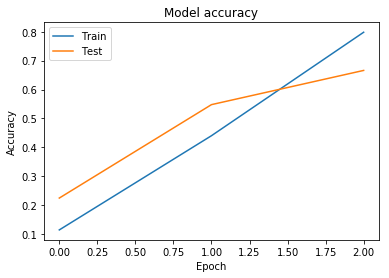

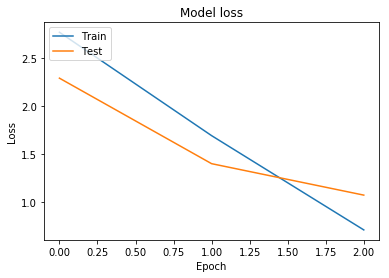

In [384]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()